In [1]:
from openpile.construct import Pile, SoilProfile, Layer, Model
from openpile.soilmodels import API_clay, API_sand, frankeRollins2013
from openpile.analyze import winkler
from scipy.optimize import fsolve

import pandas as pd
import os

In [2]:
# Get the current working directory
cwd = os.getcwd()
# Read the CSV file (replace 'filename.csv' with your actual file name)
dfPileConfig = pd.read_csv(os.path.join(cwd, 'pileConfig-pier3-static.csv'))
dfPileConfig.index.name = 'id'
dfPileConfig

,diameter[m],length[m],factored-axial-load[kN],initial-lateral-load[kN]
id,,,,
0,1.5,30,1820,150
1,1.5,35,2165,150
2,1.5,40,4960,145
3,1.5,45,6685,145
4,1.5,50,8500,145
5,2.0,30,2595,350
6,2.0,35,3055,355
7,2.0,40,7410,325
8,2.0,45,9710,320


In [3]:
sp = SoilProfile(
    name="pier3-Static",
    top_elevation=0.0,
    water_line=13.10,
    layers=[
        Layer(
            name="Soft Clay",
            top=0,
            bottom=-12.0,
            weight=14.0,
            lateral_model=API_clay(Su=15, eps50=1.98/100, kind="static"),
        ),
        Layer(
            name="Medium Stiff to Stiff Clay",
            top=-12.0,
            bottom=-36.0,
            weight=17.0,
            lateral_model=API_clay(Su=59, eps50=0.84/100, kind="static", georgiadis=True, d_adj=-7.58766620226229),
        ),
        Layer(
            name="Medium Dense to Dense Sand",
            top=-36.0,
            bottom=-52.5,
            weight=18.0,
            lateral_model=API_sand(phi=37, kind="static", georgiadis=True, d_adj=-29.41289609926034),
        ),
        Layer(
            name="Very Dense Sand",
            top=-52.5,
            bottom=-60.0,
            weight=20.0,
            lateral_model=API_sand(phi=40, kind="static", georgiadis=True, d_adj=-32.66008412623744),
        ),
    ],
)

In [4]:
# List solved shear values
solutions = []

for index, row in dfPileConfig.iterrows():
    print(f"""
          
          ========================================================================
          diameter: {row['diameter[m]']} m\t length: {row['length[m]']} m
          ========================================================================

          """)

    p = Pile(name = "pier3",
        kind='Solid-Circle',
        material='Concrete',
        top_elevation = 13.10,
        pile_sections={
            'length': [row['length[m]'] + 13.10],
            'diameter': [row['diameter[m]']],
            'wall thickness': [1e-10],
            # 'E': [248700620.3], # Young's Modulus
            # 'area': [1.767146],
            # 'I': [2.48505],
            # 'width': [1.5],
            # 'tip_area': [ 1.767146]
            
        }
    )

    # Create Model
    M = Model(name="pier3", 
            pile=p, 
            soil=sp, 
            element_type="Timoshenko", #Timoshenko
            coarseness=0.5)
    
    # Apply bottom fixity along x-axis

    M.set_support(elevation= (-1 * row['length[m]']), Tx=True)
    M.set_support(elevation=13.10, Rz=True)

    axial = row['factored-axial-load[kN]']

    M.set_pointload(elevation=13.10, Px=-axial)
    M.set_pointdisplacement(elevation=13.10, Ty=0.024999)

    Result = winkler(M)

    topDeflection = Result.deflection['Deflection [m]'].iloc[0]

    topShear = Result.forces[["V [kN]"]].iloc[0]

    print(f"\nSolved shear value corresponding to {topDeflection} mm deflection: {topShear[0]:.4f} kN\n")

    solutions.append(topShear.iloc[0])

    # # Solve for shear load
    # def analysis(axial, shear):

    #     M.set_pointload(elevation=13.10, Px=axial, Py=shear)
    #     # Run analysis

    #     Result = winkler(M)

    #     print(f"Axial: {axial} kN\tShear: {float(shear):.4f} kN\tDeflection: {float(Result.deflection['Deflection [m]'].iloc[0])*1000:.4f} mm")

    #     return Result.deflection['Deflection [m]'].iloc[0] 

    # goal = 0.024999  # allowable deflection of 0.025 m

    # solution = fsolve(lambda x: analysis(axial = row['factored-axial-load[kN]'], shear = x) - goal, 
    # x0=row['initial-lateral-load[kN]'],
    # xtol=1e-3, 
    # maxfev=4)

    # print(f"\nSolved shear value corresponding to {goal*1000} mm deflection: {solution[0]:.4f} kN\n")

    # solutions.append(solution[0])  # Append the solution to the list

# Add solutions as a new column to the DataFrame
dfPileConfig['solved-lateral-load[kN]'] = solutions




          
          diameter: 1.5 m	 length: 30.0 m

          
Converged at iteration no. 7

Solved shear value corresponding to 0.024999 mm deflection: 152.4225 kN


          
          diameter: 1.5 m	 length: 35.0 m

          
Converged at iteration no. 7

Solved shear value corresponding to 0.024999 mm deflection: 152.0534 kN


          
          diameter: 1.5 m	 length: 40.0 m

          
Converged at iteration no. 6

Solved shear value corresponding to 0.024999 mm deflection: 149.0803 kN


          
          diameter: 1.5 m	 length: 45.0 m

          
Converged at iteration no. 6

Solved shear value corresponding to 0.024999 mm deflection: 147.2159 kN


          
          diameter: 1.5 m	 length: 50.0 m

          
Converged at iteration no. 6

Solved shear value corresponding to 0.024999 mm deflection: 145.2255 kN


          
          diameter: 2.0 m	 length: 30.0 m

          
Converged at iteration no. 8

Solved shear value corresponding to 0.024999 mm deflection:

In [ ]:
dfPileConfig.to_clipboard(index=True)

In [6]:
deflectionList = []
forceList = []
pySpringList = []
modelList = []
resultList = []

for index, row in dfPileConfig.iterrows():  


    p = Pile(name = "pier3",
        kind='Solid-Circle',
        material='Concrete',
        top_elevation = 13.10,
        pile_sections={
            'length': [row['length[m]'] + 13.10],
            'diameter': [row['diameter[m]']],
            'wall thickness': [1e-10],
            # 'E': [248700620.3], # Young's Modulus
            # 'area': [1.767146],
            # 'I': [2.48505],
            # 'width': [1.5],
            # 'tip_area': [ 1.767146]
            
        }
    )

    # Create Model
    M = Model(name=f"pier3-static-fixed-{row['diameter[m]']}D-{row['length[m]']}L:", 
            pile=p, 
            soil=sp, 
            element_type="EulerBernoulli", #Timoshenko
            coarseness=0.5)
    
    # Apply bottom fixity along x-axis
    M.set_support(elevation= (-1 * row['length[m]']), Tx=True)
    M.set_support(elevation=13.10, Rz=True)

    M.set_pointload(elevation=13.10, Px=-row['factored-axial-load[kN]'], Py=row['solved-lateral-load[kN]'])
    # Run analysis

    Result = winkler(M)

    print(f"""
        id: {index}\tdiameter: {row['diameter[m]']} m\tlength: {row['length[m]']} m\tAxial: {row['factored-axial-load[kN]']} kN\tShear: {row['solved-lateral-load[kN]']:.4f} kN\tDeflection: {float(Result.deflection['Deflection [m]'].iloc[0])*1000:.4f} mm
        """)
    
    deflectionList.append(Result.deflection)  # Append the solution to the list
    forceList.append(Result.forces)
    pySpringList.append(M.get_py_springs(kind='element'))
    modelList.append(M)
    resultList.append(Result)

Converged at iteration no. 8

        id: 0	diameter: 1.5 m	length: 30.0 m	Axial: 1820.0 kN	Shear: 152.4191 kN	Deflection: 24.9001 mm
        


c:\Users\AMH-L143\anaconda3\envs\openPile-mk2\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


Converged at iteration no. 8

        id: 1	diameter: 1.5 m	length: 35.0 m	Axial: 2165.0 kN	Shear: 152.0300 kN	Deflection: 24.9007 mm
        
Converged at iteration no. 7

        id: 2	diameter: 1.5 m	length: 40.0 m	Axial: 4960.0 kN	Shear: 149.0778 kN	Deflection: 24.9461 mm
        
Converged at iteration no. 7

        id: 3	diameter: 1.5 m	length: 45.0 m	Axial: 6685.0 kN	Shear: 147.2142 kN	Deflection: 24.9727 mm
        
Converged at iteration no. 6

        id: 4	diameter: 1.5 m	length: 50.0 m	Axial: 8500.0 kN	Shear: 145.2304 kN	Deflection: 24.9511 mm
        
Converged at iteration no. 8

        id: 5	diameter: 2.0 m	length: 30.0 m	Axial: 2595.0 kN	Shear: 331.0394 kN	Deflection: 24.8400 mm
        
Converged at iteration no. 8

        id: 6	diameter: 2.0 m	length: 35.0 m	Axial: 3055.0 kN	Shear: 330.6094 kN	Deflection: 24.8435 mm
        
Converged at iteration no. 7

        id: 7	diameter: 2.0 m	length: 40.0 m	Axial: 7410.0 kN	Shear: 326.6147 kN	Deflection: 24.8587 mm
        

In [7]:
import pickle

with open('pier3-static/dfPileConfig.pkl', 'wb') as file:
    pickle.dump(dfPileConfig, file)
with open('pier3-static/deflectionList.pkl', 'wb') as file:
    pickle.dump(deflectionList, file)
with open('pier3-static/forceList.pkl', 'wb') as file:
    pickle.dump(forceList, file)
with open('pier3-static/pySpringList.pkl', 'wb') as file:
    pickle.dump(pySpringList, file)
with open('pier3-static/modelList.pkl', 'wb') as file:
    pickle.dump(modelList, file)
with open('pier3-static/resultList.pkl', 'wb') as file:
    pickle.dump(resultList, file)

In [8]:
import pickle

# Load from file
with open('pier3-static/dfPileConfig.pkl', 'rb') as file:
    dfPileConfig = pickle.load(file)
with open('pier3-static/deflectionList.pkl', 'rb') as file:
    deflectionList = pickle.load(file)
with open('pier3-static/forceList.pkl', 'rb') as file:
    forceList = pickle.load(file)
with open('pier3-static/pySpringList.pkl', 'rb') as file:
    pySpringList = pickle.load(file)
with open('pier3-static/modelList.pkl', 'rb') as file:
    modelList = pickle.load(file)
with open('pier3-static/resultList.pkl', 'rb') as file:
    resultList = pickle.load(file)

In [19]:
# dfPileConfig.to_clipboard(index=True)
# forceList[9].to_clipboard(index=True)
# deflectionList[9].to_clipboard(index=True)
pySpringList[9].to_clipboard(index=True)
# modelList[9].plot()

In [10]:
deflectionList[9].to_clipboard(index=True)

In [11]:
pySpringList[9].to_clipboard(index=True)

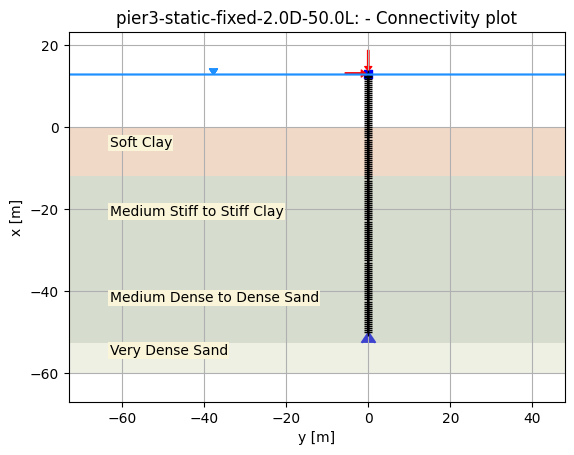

In [12]:
modelList[9].plot()

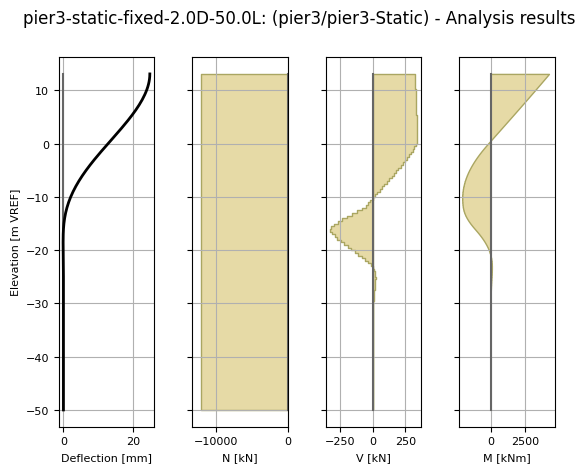

In [13]:
resultList[9].plot()

In [14]:
print(modelList[9])

     x_top [m]  x_bottom [m]  y_top [m]  y_bottom [m]  Diameter [m]  Wall thickness [m]  Area [m2]    I [m4]       E [kPa]
0       13.100        12.615        0.0           0.0           2.0        1.000000e-10   3.141593  0.785398  2.487006e+07
1       12.615        12.130        0.0           0.0           2.0        1.000000e-10   3.141593  0.785398  2.487006e+07
2       12.130        11.644        0.0           0.0           2.0        1.000000e-10   3.141593  0.785398  2.487006e+07
3       11.644        11.159        0.0           0.0           2.0        1.000000e-10   3.141593  0.785398  2.487006e+07
4       11.159        10.674        0.0           0.0           2.0        1.000000e-10   3.141593  0.785398  2.487006e+07
5       10.674        10.189        0.0           0.0           2.0        1.000000e-10   3.141593  0.785398  2.487006e+07
6       10.189         9.704        0.0           0.0           2.0        1.000000e-10   3.141593  0.785398  2.487006e+07
7        9.704  

In [15]:
modelList[9].get_soil_properties().to_clipboard(index=True)